# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [87]:
import io
import os
import numpy as np
import scipy

In [88]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [89]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict(zip(self.word2vec.keys(), range(len(self.word2vec))))
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        fun = np.vectorize(lambda v: self.score(self.id2word[v],w))
        scores = fun(np.arange(len(self.word2vec)))
        ids = np.argsort(-scores)[:K+1]
        return [self.id2word[idx] for idx in ids]

    def score(self, w1, w2, words = True):
        # cosine similarity: np.dot  -  np.linalg.norm
        if words : w1, w2 = self.word2vec[w1], self.word2vec[w2] 
        return np.dot(w1, w2)/(np.linalg.norm(w1)*np.linalg.norm(w2))

In [90]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=60000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2)) 
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 60000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['cat', 'cats', 'kitty', 'kitten', 'feline', 'kitties']
['dog', 'dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dogs', 'dog', 'Dogs', 'doggies', 'canines', 'puppies']
['paris', 'france', 'Paris', 'london', 'berlin', 'europe']
['germany', 'europe', 'german', 'berlin', 'france', 'italy']


In [91]:
class BoV():
    def __init__(self, w2v, dim = 300):
        self.w2v = w2v
        self.dim = dim
        self.idf_dict = None
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        if idf : weights = self.idf_dict
        sentemb = []
        for sent in sentences:
            if not idf:
                # mean of word vectors
                mean = np.nanmean([self.w2v.word2vec.get(w, np.full(self.dim,np.nan)) for w in sent], axis=0)
                sentemb.append(mean)
            else:
                # idf-weighted mean of word vectors
                normalize = np.sum([weights[w] if w in self.w2v.word2vec.keys() else 0 for w in sent])
                weighted_sum = np.nansum([weights[w]*self.w2v.word2vec.get(w, np.full(self.dim,np.nan)) for w in sent], axis=0)
                sentemb.append(weighted_sum/normalize)
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        fun = lambda x : self.score(x, query.ravel(), words=False)
        similarities = np.apply_along_axis(fun, 1, keys)
        sort = np.argsort(-similarities)[:K+1]
        for i in sort : print(' '.join(sentences[i])) 

    def score(self, s1, s2, idf=False, words= True):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        if words : s1, s2 = self.encode([s1], idf).ravel(), self.encode([s2], idf).ravel()
        return np.dot(s1, s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        n = len(sentences)
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        self.idf_dict = {word: max(1, np.log10(n/v)) for word, v in idf.items()} 


In [92]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA, 'sentences.txt')) as txt :
    sentences = [sent.strip().split() for sent in txt.readlines()]

# Build idf scores for each word
s2v.build_idf(sentences)


print('\n similarity using mean:')

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

print('\n similarity using idf:')

idf = True
# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 50000 pretrained word vectors

 similarity using mean:
1 smiling african american boy .
an african american man smiling .
a little african american boy and girl looking up .
an african american in sunglasses and a white tee-shirt smiles .
an afican american woman standing behind two small african american children .
an african american man is sitting .
0.5726258859719607

 similarity using idf:
1 smiling african american boy .
an african american man smiling .
a little african american boy and girl looking up .
an african american in sunglasses and a white tee-shirt smiles .
an afican american woman standing behind two small african american children .
an african american man is sitting .
0.4751450875368781


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [93]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

#you'll need to install wget if you don't have it.
!pip install wget
import wget

print('Beginning file download:')
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec'
wget.download(url, out ='en.vec')  

url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec'
wget.download(url, out ='fr.vec')
print('Done!')

f2v = Word2vec(os.path.join(PATH_TO_DATA, 'fr.vec'), nmax=50000)
e2v = Word2vec(os.path.join(PATH_TO_DATA, 'en.vec'), nmax=50000)

Beginning file download:
Done!
Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [94]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
in_common = []
fr_vocab, en_vocab = f2v.word2id.keys(), e2v.word2id.keys()
for word in fr_vocab: 
    if word in en_vocab : in_common.append(word)
        
X = np.array([f2v.word2vec[word] for word in in_common]).T
Y = np.array([e2v.word2vec[word] for word in in_common]).T

In [95]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
from scipy.linalg import svd

U, _, V = svd(Y.dot(X.T))
W = U.dot(V)

In [96]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE


rng = np.random.RandomState(1)
chosen = rng.randint(0, 5e4, size = 3)
score = f2v.score

K = 5
print('French to English similarities:')
eng_embedding = e2v.embeddings
for idx in chosen:
    aligned = W.dot(f2v.embeddings[idx])
    fun = lambda emb : score(emb , aligned , words=False)
    similarities = np.apply_along_axis(fun, 1, eng_embedding)
    sort = np.argsort(-similarities)[:K+1]
    print("the translation of "+ f2v.id2word[idx] +":", [e2v.id2word[eng] for eng in sort])

    
chosen = rng.randint(0, 5e4, size = 3)

print('\nEnglish to French similarities:')
fr_embedding = f2v.embeddings
for idx in chosen:
    aligned = W.T.dot(e2v.embeddings[idx])
    fun = lambda emb : score(emb , aligned , words=False)
    similarities = np.apply_along_axis(fun, 1, fr_embedding)
    sort = np.argsort(-similarities)[:K+1]
    print("the translation of "+ e2v.id2word[idx] +":", [f2v.id2word[eng] for eng in sort])




French to English similarities:
the translation of auvergnat: ['occitan', 'limousin', 'provençal', 'dôme', 'auvergne', 'puy']
the translation of segments: ['segments', 'segmented', 'segment', 'segmentation', 'segmental', 'edges']
the translation of crimes: ['crimes', 'perpetrators', 'atrocities', 'complicity', 'criminals', 'prosecutions']

English to French similarities:
the translation of penchant: ['penchant', 'provocateur', 'sarcastique', 'plaisanteries', 'propension', 'dérision']
the translation of monogamous: ['femelles', 'mâles', 'nidification', 'sexes', 'couples', 'femelle']
the translation of tagging: ['wikification', 'reverté', 'modifs', 'salebot', 'modif', 'reverter']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [97]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_txt(PATH, labels=True):
    with open(PATH) as txt :
        if labels :
            sentences, y_sentences = [], []
            for sent in txt.readlines():
                sentences.append(sent[1:].strip().split())
                y_sentences.append(int(sent[0].strip()))
            return sentences, np.array(y_sentences)
        return [sent.strip().split() for sent in txt.readlines()]

train, y_train = load_txt(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev, y_dev = load_txt(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test = load_txt(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), labels=False)

In [98]:
# 2 - Encode sentences with the BoV model above
s2v = BoV(w2v)

X_train = s2v.encode(train)
X_dev = s2v.encode(dev)

s2v.build_idf(train + dev)
X_train_idf = s2v.encode(train, idf=True)
X_dev_idf = s2v.encode(dev, idf=True)

the best C value for mean BoV is 10.00 with a score of  (train :0.500, val:0.426):
the best C value for idf BoV is 0.10 with a score of  (train :0.460, val:0.421):


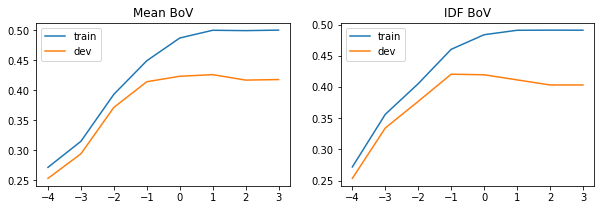

In [99]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

interval = np.arange(-4,4)
penalisations = 10.0**interval
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
train_acc, dev_acc = [], []
for pen in penalisations:
    model = LogisticRegression(C = pen, multi_class='multinomial', solver='newton-cg')
    model.fit(X_train, y_train)
    train_acc.append(model.score(X_train, y_train))
    dev_acc.append(model.score(X_dev, y_dev))
    
print("the best C value for mean BoV is %.2f with a score of  (train :%.3f, val:%.3f):"%(penalisations[np.argmax(dev_acc)], 
                                                                                        train_acc[np.argmax(dev_acc)],max(dev_acc)))
    
plt.plot(interval, train_acc, label='train')
plt.plot(interval, dev_acc, label='dev')
plt.title('Mean BoV')
plt.legend()


plt.subplot(1,2,2)
train_acc, dev_acc = [], []
for pen in penalisations:
    model = LogisticRegression(C = pen, multi_class='multinomial', solver='newton-cg')
    model.fit(X_train_idf, y_train)
    train_acc.append(model.score(X_train_idf, y_train))
    dev_acc.append(model.score(X_dev_idf, y_dev))
    
print("the best C value for idf BoV is %.2f with a score of  (train :%.3f, val:%.3f):"%(penalisations[np.argmax(dev_acc)], 
                                                                                        train_acc[np.argmax(dev_acc)],max(dev_acc)))

plt.plot(interval, train_acc, label='train')
plt.plot(interval, dev_acc, label='dev')
plt.title('IDF BoV')
plt.legend()

plt.show()

In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

X_test = s2v.encode(test)
model = LogisticRegression(C=10.00)
#we train it on all of the data available
model.fit(np.vstack((X_train, X_dev)), np.concatenate((y_train, y_dev)))
y_test = model.predict(X_test)

np.savetxt(os.path.join(PATH_TO_DATA, 'logreg_bov_y_test_sst.txt'), y_test, fmt= '%d')

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# I tried SVM and Random Forests but nothing seemed to work better than Logisitic Regression

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [17]:
import keras

In [18]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

def load_raw_txt(PATH, labels=True):
    with open(PATH) as txt :
        if labels :
            sentences, y_sentences = [], []
            for sent in txt.readlines():
                sentences.append(sent[1:].strip())
                y_sentences.append(int(sent[0].strip()))
            return sentences, np.array(y_sentences)
        return [sent.strip() for sent in txt.readlines()]

# TYPE CODE HERE
train, y_train = load_raw_txt(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev, y_dev = load_raw_txt(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test = load_raw_txt(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), labels=False)

In [19]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing.text import text_to_word_sequence

train_proc = list(map(text_to_word_sequence, train))
dev_proc = list(map(text_to_word_sequence, dev))
test_proc = list(map(text_to_word_sequence, test))

flatten = lambda array : [word for sentence in array for word in sentence]

# we use our own function, one hot doesn't guarantee the unicity of the assignment
vocab = list(set(flatten(train_proc + dev_proc + test_proc)))
id2word = dict(enumerate(vocab))
word2id = {v: k for k, v in id2word.items()}

train_id = [[word2id[x] for x in sentence] for sentence in train_proc]
dev_id = [[word2id[x] for x in sentence] for sentence in dev_proc]
test_id = [[word2id[x] for x in sentence] for sentence in test_proc]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [20]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/
from keras.preprocessing.sequence import pad_sequences

#compute the maximum length we have
maxlen = max(map(len, train_proc + dev_proc + test_proc))

X_train = pad_sequences(train_id, maxlen=maxlen)
X_dev = pad_sequences(dev_id, maxlen=maxlen)
X_test = pad_sequences(test_id, maxlen=maxlen)

huge_w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=2e5)

Loaded 200000 pretrained word vectors


## 4.2 - Design and train your model

In [24]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.regularizers import l2

embed_dim  = 300  # word embedding dimension
nhid       = 32  # number of hidden units in the LSTM
vocab_size = len(id2word)  # size of the vocabulary
embedding_matrix = np.array(list(map(lambda word : huge_w2v.word2vec.get(word, np.zeros(embed_dim)), vocab)))
n_classes  = 5

def rnn_model(nhid = nhid):
    model = Sequential()
    model.add(Embedding(vocab_size,embed_dim,
                        weights = [embedding_matrix],
                        input_length= maxlen, trainable=False))
    model.add(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(1e-5)))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [30]:
# 5 - Define your loss/optimizer/metrics
from keras.optimizers import RMSprop, Adam, SGD

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  RMSprop(lr = 0.001) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras

model = rnn_model(nhid=32)

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 52, 300)           5351700   
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 5,394,489
Trainable params: 42,789
Non-trainable params: 5,351,700
_________________________________________________________________


Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8544/8544 [==============================] - 6s 706us/step - loss: 1.5543 - acc: 0.2987 - val_loss: 1.5009 - val_acc: 0.3479
Epoch 2/20
8544/8544 [==============================] - 5s 580us/step - loss: 1.4776 - acc: 0.3413 - val_loss: 1.3907 - val_acc: 0.3906
Epoch 3/20
8544/8544 [==============================] - 5s 575us/step - loss: 1.4173 - acc: 0.3762 - val_loss: 1.3435 - val_acc: 0.4033
Epoch 4/20
8544/8544 [==============================] - 5s 588us/step - loss: 1.3897 - acc: 0.3942 - val_loss: 1.3254 - val_acc: 0.4133
Epoch 5/20
8544/8544 [==============================] - 5s 581us/step - loss: 1.3657 - acc: 0.4034 - val_loss: 1.3120 - val_acc: 0.4205
Epoch 6/20
8544/8544 [==============================] - 5s 581us/step - loss: 1.3523 - acc: 0.4095 - val_loss: 1.3032 - val_acc: 0.4160
Epoch 7/20
8544/8544 [==============================] - 5s 594us/step - loss: 1.3385 - acc: 0.4209 - val_loss: 1.2905 - val_acc: 0.4278


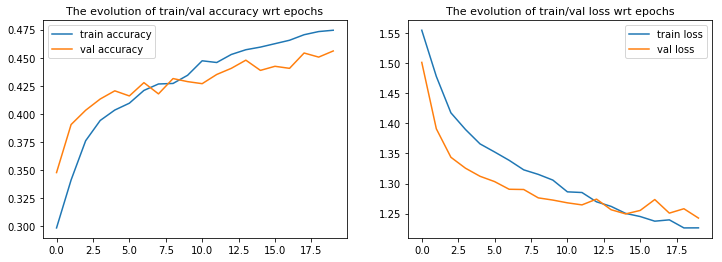

In [31]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 128
n_epochs = 20

oh_train, oh_dev = np.eye(n_classes)[y_train], np.eye(n_classes)[y_dev]

history = model.fit(X_train, oh_train, batch_size=bs, epochs =n_epochs, validation_data=(X_dev, oh_dev))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label= 'train accuracy')
plt.plot(history.history['val_acc'], label= 'val accuracy')
plt.legend()
plt.title('The evolution of train/val accuracy wrt epochs', fontsize=11)
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label= 'train loss')
plt.plot(history.history['val_loss'], label= 'val loss')
plt.legend()
plt.title('The evolution of train/val loss wrt epochs', fontsize=11)
plt.show()

In [32]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

final_model = rnn_model(nhid=32)
final_model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

final_model.fit(np.vstack([X_train, X_dev]), np.vstack([oh_train, oh_dev]), batch_size= bs, epochs=n_epochs ,verbose=0)
y_pred = model.predict(X_test)

np.savetxt(os.path.join(PATH_TO_DATA, 'logreg_lstm_y_test_sst.txt'), np.argmax(y_pred, axis=1), fmt= '%d')

## 4.3 -- innovate !

In [85]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from keras.layers import Concatenate, Conv1D, Input, MaxPool1D, Flatten, Dropout, AvgPool1D, Bidirectional
from keras.regularizers import l2
from keras.models import Model

# def model_cnn(filter_sizes, nb_ftrs = 8, reg = 1e-3):
#     input_model = Input(shape=(maxlen,))
#     layer = Embedding(vocab_size, embed_dim, weights = [embedding_matrix], input_length= maxlen, trainable=False)(input_model)
#     convs = [AvgPool1D((maxlen - fsize + 1))(Conv1D(nb_ftrs, (fsize), 
#              activation='relu', kernel_regularizer= l2(reg) )(layer)) for fsize in filter_sizes]
#     concat = Concatenate(axis=2)(convs)
#     flat = Flatten()(concat)
#     output = Dense(n_classes, activation='softmax')(flat)
#     model = Model(input_model, output)
#     return model  

def model_bilstm(nhid = 32):
    model = Sequential()
    model.add(Embedding(vocab_size,embed_dim,
                        weights = [embedding_matrix],
                        input_length= maxlen, trainable=False))
    model.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(1e-5))))
    model.add(Dense(n_classes, activation='softmax'))
    return model

bilstm = model_bilstm()
bilstm.compile(loss=loss_classif,
            optimizer= Adam(),
            metrics=metrics_classif)

bilstm.fit(X_train, oh_train, batch_size=128, epochs =20, validation_data=(X_dev, oh_dev))


inno_model = model_bilstm(nhid=32)
inno_model.compile(loss=loss_classif,
              optimizer=Adam(),
              metrics=metrics_classif)

inno_model.fit(np.vstack([X_train, X_dev]), np.vstack([oh_train, oh_dev]), batch_size= 128, epochs=20 ,verbose=0)
y_pred = inno_model.predict(X_test)

np.savetxt(os.path.join(PATH_TO_DATA, 'logreg_bilstm_y_test_sst.txt'), np.argmax(y_pred, axis=1), fmt= '%d')

Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8544/8544 [==============================] - 11s 1ms/step - loss: 1.5753 - acc: 0.2794 - val_loss: 1.5356 - val_acc: 0.3206
Epoch 2/20
8544/8544 [==============================] - 8s 955us/step - loss: 1.5010 - acc: 0.3443 - val_loss: 1.4045 - val_acc: 0.3824
Epoch 3/20
8544/8544 [==============================] - 8s 973us/step - loss: 1.4253 - acc: 0.3739 - val_loss: 1.3427 - val_acc: 0.4078
Epoch 4/20
8544/8544 [==============================] - 8s 962us/step - loss: 1.3781 - acc: 0.3960 - val_loss: 1.3130 - val_acc: 0.4078
Epoch 5/20
8544/8544 [==============================] - 8s 957us/step - loss: 1.3623 - acc: 0.4045 - val_loss: 1.3007 - val_acc: 0.4260
Epoch 6/20
8544/8544 [==============================] - 8s 959us/step - loss: 1.3454 - acc: 0.4143 - val_loss: 1.2886 - val_acc: 0.4296
Epoch 7/20
8544/8544 [==============================] - 8s 962us/step - loss: 1.3316 - acc: 0.4202 - val_loss: 1.3012 - val_acc: 0.4223
E